<a href="https://colab.research.google.com/github/Greg9998/Demo111/blob/master/HARP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
# clear all
from IPython import get_ipython
get_ipython().magic('reset -sf')

Libraries, data read, preprocessing and subsets generation

In [42]:
import numpy as np # Library for matrix operations and numerical computations
import pandas as pd # Library for data manipulation and analysis, CSV file handling
import seaborn as sns # Library for creating attractive statistical plots
import matplotlib.pyplot as plt # Library for creating plots and data visualizatio
import warnings # Library for handling warnings and message
import sklearn.metrics
from sklearn.metrics import (confusion_matrix, classification_report,
                             RocCurveDisplay, accuracy_score, precision_score,
                             recall_score, f1_score) # evaluating machine learning model results
from sklearn.preprocessing import (OrdinalEncoder, MinMaxScaler, StandardScaler) # Library for data preprocessing
from sklearn.model_selection import (cross_validate, cross_val_score,
                          RandomizedSearchCV, GridSearchCV, train_test_split) #machine learning model selection
from sklearn.pipeline import make_pipeline # Library for creating data processing pipelines
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis # Implementation of Quadratic Discriminant Analysis in scikit-learn
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier #Implementations of AdaBoost and Random Forest algorithms
from sklearn.gaussian_process import GaussianProcessClassifier # Implementation of a classifier based on Gaussian Process
from sklearn.gaussian_process.kernels import RBF # Implementation of the RBF kernel function for Gaussian Process
from sklearn.inspection import DecisionBoundaryDisplay # Library for visualizing decision boundaries of models
from sklearn.naive_bayes import GaussianNB # Implementation of the Naive Bayes classification algorithm
from sklearn.neighbors import KNeighborsClassifier # Implementation of the k-nearest neighbors algorithm
from sklearn.neural_network import MLPClassifier # Implementation of the Multi-Layer Perceptron classifier
from sklearn.svm import SVC # Implementation of Support Vector Machine in scikit-learn
from sklearn.tree import DecisionTreeClassifier # Implementation of the decision tree classifier

#Settings the warnings to be ignored
warnings.filterwarnings('ignore')

#Read data
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/heart_disease.csv')
data0 = data.copy()

#Descriptive statistics function
def summary(df):
    print('data shape: ',df.shape)
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['missing'] = df.isnull().sum().values
    summ['%miss'] = df.isnull().sum().values / len(df)
    summ['unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['Quant1'] = df.quantile(0.25)
    summ['median'] = df.quantile(0.5)
    summ['Quant3'] = df.quantile(0.75)
    summ['max'] = desc['max'].values
    summ['mean'] = df.mean()
    summ['std'] = df.std()
    summ['skew'] = df.skew()
    summ['kurt'] = df.kurt()
    return summ

#Missing values removal
data.dropna(inplace=True)

#Categorical replacement into int
## naturaly progression integers
enc = OrdinalEncoder(categories=[['uneducated','primaryschool','graduate','postgraduate']])
enc.fit(data[['education']])
data[['education']] = enc.transform(data[['education']])

## binary vals
enc = OrdinalEncoder()
enc.fit(data[['Gender','prevalentStroke','Heart_ stroke']])
data[['Gender','prevalentStroke','Heart_ stroke']] = enc.transform(data[['Gender','prevalentStroke','Heart_ stroke']])

#Outliers removal
outliersThreshold = 0.005

q_low = data.quantile(outliersThreshold)
q_hi = data.quantile(1-outliersThreshold)
logic = True
for col in data.columns:
  logic = logic & (data[col]<=q_hi[col]) & (data[col]>=q_low[col])
data2 = data[logic]

#delete unnecessary variables
del enc, col, logic, q_low, q_hi

#Train-test-validation split function
def train_test_valid_split(target,data,rTR=60,rTE=20,rVA=20):
  rTT=1-rTR/(rTR+rTE+rVA) #remaining fraction after train subset generation
  rTV=rTE/(rTE+rVA) #test vs validation subset fraction
  x_train, x_test, y_train, y_test = train_test_split(target, data, test_size=rTT, random_state=12)
  x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=rTV, random_state=13)
  return x_train, x_test, x_valid, y_train, y_test, y_valid

#Split data2 into training, testing and validation subsets
## chosen features
xc = data2[['age', 'sysBP', 'diaBP', 'glucose']]
## extract target
x = data2.drop(['Heart_ stroke','age', 'sysBP','diaBP', 'glucose'], axis = 1)
xa = data2.drop(['Heart_ stroke'], axis = 1)
y = data2['Heart_ stroke']

#standardisation
standard_scaler = StandardScaler().set_output(transform="pandas")
x = standard_scaler.fit_transform(x)
xc = standard_scaler.fit_transform(xc)
xa = standard_scaler.fit_transform(xa)

## Split data2 (with 'c' - subsets with only chosen features)
xc_train, xc_test, xc_valid, yc_train, yc_test, yc_valid = train_test_valid_split(xc,y,80,10,10)
xa_train, xa_test, xa_valid, ya_train, ya_test, ya_valid = train_test_valid_split(xa,y,80,10,10)
x_train, x_test, x_valid, y_train, y_test, y_valid = train_test_valid_split(x,y,80,10,10)

#sklearn.metrics accuracy and precision print function
def sklmetrics(y_train,y_pred_train,y_valid,y_pred_valid):
  acc_train = accuracy_score(y_train, y_pred_train)
  acc_valid = accuracy_score(y_valid, y_pred_valid)
  prec_train = precision_score(y_train, y_pred_train)
  prec_valid = precision_score(y_valid, y_pred_valid)
  print(f'Train accuracy = {acc_train:.7f}\nValid accuracy = {acc_valid:.7f}')
  print(f'Train precision = {prec_train:.7f}\nValid precision = {prec_valid:.7f}')

summary(data2)

data shape:  (3441, 16)


,data type,missing,%miss,unique,min,Quant1,median,Quant3,max,mean,std,skew,kurt
Gender,float64,0,0.0,2,0.00,0.0,0.0,1.00,1.00,0.446382,0.497189,0.215811,-1.954562
age,int64,0,0.0,35,34.00,42.0,49.0,56.00,68.00,49.473409,8.445031,0.232585,-0.999850
education,float64,0,0.0,4,0.00,0.0,1.0,2.00,3.00,0.993316,1.027648,0.671072,-0.755260
currentSmoker,int64,0,0.0,2,0.00,0.0,0.0,1.00,1.00,0.487940,0.499927,0.048277,-1.998831
cigsPerDay,float64,0,0.0,29,0.00,0.0,0.0,20.00,43.00,8.880267,11.568535,1.090714,0.207265
BPMeds,float64,0,0.0,2,0.00,0.0,0.0,0.00,1.00,0.027027,0.162186,5.835878,32.076111
prevalentStroke,float64,0,0.0,2,0.00,0.0,0.0,0.00,1.00,0.005812,0.076027,13.007819,167.300589
prevalentHyp,int64,0,0.0,2,0.00,0.0,0.0,1.00,1.00,0.303110,0.459669,0.857160,-1.266013
diabetes,int64,0,0.0,2,0.00,0.0,0.0,0.00,1.00,0.021215,0.144121,6.648097,42.221730
totChol,float64,0,0.0,214,150.00,207.0,234.0,264.00,372.00,236.859924,41.526310,0.359809,-0.132466


,Nearest_Neighbors,Linear_SVM,RBF_SVM,Decision_Tree,Random_Forest,Neural_Net,AdaBoost,Naive_Bayes,QDA
Mean fit time,0.006214,0.113937,0.128334,0.011731,0.023932,11.168354,0.131132,0.002795,0.004254
Train accuracy,0.857558,0.852108,0.782703,0.909520,0.886628,0.877907,0.853924,0.831395,0.831395
Train precision,0.636364,0.000000,0.160142,0.964706,0.943925,0.873684,0.692308,0.300699,0.303448
Train recall,0.085995,0.000000,0.110565,0.402948,0.248157,0.203931,0.022113,0.105651,0.108108
Train f1,0.151515,0.000000,0.130814,0.568458,0.392996,0.330677,0.042857,0.156364,0.159420
Valid accuracy,0.851744,0.860465,0.805233,0.796512,0.845930,0.851744,0.857558,0.831395,0.831395
Valid precision,0.333333,0.000000,0.172414,0.107143,0.222222,0.285714,0.000000,0.222222,0.222222
Valid recall,0.062500,0.000000,0.104167,0.062500,0.041667,0.041667,0.000000,0.083333,0.083333
Valid f1,0.151515,0.000000,0.130814,0.568458,0.392996,0.330677,0.042857,0.156364,0.159420


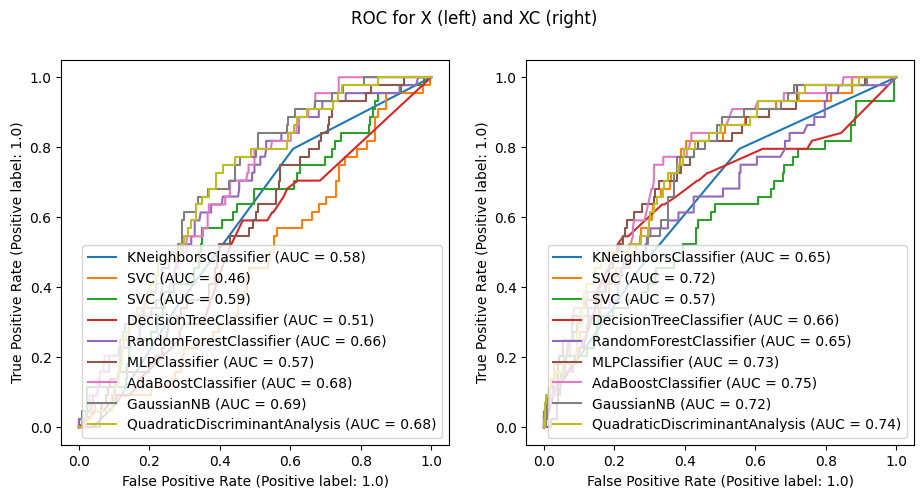

In [27]:
#Classification using different models

names = ["Nearest_Neighbors","Linear_SVM","RBF_SVM","Decision_Tree",
         "Random_Forest","Neural_Net","AdaBoost","Naive_Bayes","QDA",]

rows = ["Mean fit time","Train accuracy","Train precision","Train recall",
        "Train f1","Valid accuracy","Valid precision","Valid recall",
        "Valid f1"]

classifiers = [
    KNeighborsClassifier(7),
    SVC(kernel="linear", C=10, gamma=0.1, random_state=42),
    SVC(kernel="sigmoid", gamma=0.1, C=1, random_state=42),
    DecisionTreeClassifier(max_depth=10, random_state=42),
    RandomForestClassifier(max_depth=10, n_estimators=5, max_features='sqrt', random_state=42),
    MLPClassifier(alpha=0.01, max_iter=1000, random_state=42),
    AdaBoostClassifier(learning_rate=0.7, random_state=42),
    GaussianNB(var_smoothing=1e-8),
    QuadraticDiscriminantAnalysis(reg_param=0.2),
]

#Function for time, accuracy, precision recall and f1
def TotalRecall(clf,x_train,y_train,x_valid,y_valid,cv=3):
  y_pred_train = clf.predict(x_train)
  y_pred_valid = clf.predict(x_valid)
  clf_results = cross_validate(clf, x_train, y_train, cv=cv)
  return [(clf_results['fit_time']).mean(), #mean_fit_time
      accuracy_score(y_train, y_pred_train), #Train accuracy
      precision_score(y_train, y_pred_train), #Train precision
      recall_score(y_train, y_pred_train), #Train recall
      f1_score(y_train, y_pred_train), #Train f1
      accuracy_score(y_valid, y_pred_valid), #Valid accuracy
      precision_score(y_valid, y_pred_valid), #Valid precision
      recall_score(y_valid, y_pred_valid), #Valid recall
      f1_score(y_train, y_pred_train)] #Valid f1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
fig.suptitle('ROC for X (left) and XC (right)')

# iterate over classifiers
scoreX = pd.DataFrame([], index=rows, columns=names)
scoreXC=scoreX.copy()
for name, clf in zip(names, classifiers):
  clf.fit(x_train, y_train)
  scoreX[name]=TotalRecall(clf,x_train,y_train,x_valid,y_valid,3)
  RocCurveDisplay.from_estimator(clf,x_test, y_test, ax=ax1, name=None)
  clf.fit(xc_train, yc_train)
  scoreXC[name]=TotalRecall(clf,xc_train,yc_train,xc_valid,yc_valid,5)
  RocCurveDisplay.from_estimator(clf,xc_test, yc_test, ax=ax2, name=None)
scoreX

In [21]:
scoreXC

,Nearest_Neighbors,Linear_SVM,RBF_SVM,Decision_Tree,Random_Forest,Neural_Net,AdaBoost,Naive_Bayes,QDA
Mean fit time,0.022287,0.092250,0.082158,0.006826,0.018317,0.796723,0.127341,0.002486,0.003727
Train accuracy,0.867006,0.852108,0.797238,0.888808,0.893169,0.852471,0.856105,0.822311,0.840843
Train precision,0.735632,0.000000,0.225455,0.756345,0.937984,0.545455,0.739130,0.334677,0.365217
Train recall,0.157248,0.000000,0.152334,0.366093,0.297297,0.014742,0.041769,0.203931,0.103194
Train f1,0.259109,0.000000,0.181818,0.493377,0.451493,0.028708,0.079070,0.253435,0.160920
Valid accuracy,0.845930,0.860465,0.770349,0.816860,0.854651,0.860465,0.857558,0.819767,0.843023
Valid precision,0.272727,0.000000,0.139535,0.173913,0.375000,0.500000,0.333333,0.315789,0.363636
Valid recall,0.062500,0.000000,0.125000,0.083333,0.062500,0.020833,0.020833,0.250000,0.166667
Valid f1,0.259109,0.000000,0.181818,0.493377,0.451493,0.028708,0.079070,0.253435,0.160920


Optimisation

In [ ]:
# ---------------------- Hyperparameter optimization on chosen features--------------------------------

clf = MLPClassifier(max_iter=20000, early_stopping=True, validation_fraction=0.111, random_state=0)

parameters = {
    'hidden_layer_sizes': [(32,16,8), (64,32,16), (128,64), (64,64), (128,64,32),
                           (32,16,16), (64,32,32), (64,128,64), (32,64), (32,64,32),
                           (32,64,128), (32,16,16,8), (64,32,32,16), (64,128,64,128),
                           (32,64,32,16), (32,64,32,8), (32,64,64,32),(16,32,32,16),
                           (16,32,64,32,16), (128,64,32,16,8), (16,16,16,16,16), (32,32)],
    'activation': ['tanh', 'relu','logistic'],
    'solver': ['lbfgs', 'adam','sgd'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant','adaptive'],
}

grid_search = GridSearchCV(clf, parameters, cv=5, scoring='f1', n_jobs=-1,verbose=2, refit=True )
grid_search.fit(xc_train, yc_train)
y_pred_test = grid_search.predict(xc_test)

print("best params", grid_search.best_params_) # to get the best parameters
print("best estimator", grid_search.best_estimator_) # to get the best estimator

test_recall = sklearn.metrics.recall_score(yc_test, y_pred_test),  # Test recall
test_accuracy = sklearn.metrics.accuracy_score(yc_test, y_pred_test),  # Test accuracy
test_precision = sklearn.metrics.precision_score(yc_test, y_pred_test),  # Test precision

print("test recall",test_recall)
print("test accuracy",test_accuracy)
print("test precision",test_precision)

df = pd.DataFrame(grid_search.cv_results_)
df.to_excel('result1.xlsx')

In [ ]:
# ---------------------- Hyperparameter optimization on the rest of the features--------------------------------

clf = MLPClassifier(max_iter=20000, early_stopping=True, validation_fraction=0.111, random_state=0)

parameters = {
    'hidden_layer_sizes': [(32,16,8), (64,32,16), (128,64), (64,64), (128,64,32),
                           (32,16,16), (64,32,32), (64,128,64), (32,64), (32,64,32),
                           (32,64,128), (32,16,16,8), (64,32,32,16), (64,128,64,128),
                           (32,64,32,16), (32,64,32,8), (32,64,64,32),(16,32,32,16),
                           (16,32,64,32,16), (128,64,32,16,8), (16,16,16,16,16), (32,32)],
    'activation': ['tanh', 'relu','logistic'],
    'solver': ['lbfgs', 'adam','sgd'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant','adaptive'],
}

grid_search = GridSearchCV(clf, parameters, cv=5, scoring='f1', n_jobs=-1,verbose=2, refit=True )
grid_search.fit(x_train, y_train)
y_pred_test = grid_search.predict(x_test)

print("best params", grid_search.best_params_) # to get the best parameters
print("best estimator", grid_search.best_estimator_) # to get the best estimator

test_recall = sklearn.metrics.recall_score(y_test, y_pred_test),  # Test recall
test_accuracy = sklearn.metrics.accuracy_score(y_test, y_pred_test),  # Test accuracy
test_precision = sklearn.metrics.precision_score(y_test, y_pred_test),  # Test precision

print("test recall",test_recall)
print("test accuracy",test_accuracy)
print("test precision",test_precision)

df = pd.DataFrame(grid_search.cv_results_)
df.to_excel('result2.xlsx')

In [ ]:
# ---------------------- Hyperparameter optimization on chosen features--------------------------------

clf = svm.SVC(cache_size=2000, class_weight='balanced')
parameters = {'C': [0.1, 1, 10, 100, 1000, 10e4],
              'gamma': [0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

grid_search = GridSearchCV(clf, parameters, scoring=['recall','precision', 'f1', 'accuracy'], cv=5, n_jobs=-1,verbose=2, refit=True )
grid_search.fit(xc_train, yc_train)
y_pred_test = grid_search.predict(xc_test)

print("best params", grid_search.best_params_) # to get the best parameters
print("best estimator", grid_search.best_estimator_) # to get the best estimator

test_recall = sklearn.metrics.recall_score(yc_test, y_pred_test),  # Test recall
test_accuracy = sklearn.metrics.accuracy_score(yc_test, y_pred_test),  # Test accuracy
test_precision = sklearn.metrics.precision_score(yc_test, y_pred_test),  # Test precision

print("test recall",test_recall)
print("test accuracy",test_accuracy)
print("test precision",test_precision)

df = pd.DataFrame(grid_search.cv_results_)
df.to_excel('resultSVM1.xlsx')

In [ ]:
# ---------------------- Hyperparameter optimization on the rest of the features--------------------------------

clf = svm.SVC(cache_size=2000, class_weight='balanced')
parameters = {'C': [0.1, 1, 10, 100, 1000, 10e4],
              'gamma': [0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

grid_search = GridSearchCV(clf, parameters, cv=5, scoring='f1', n_jobs=-1,verbose=2, refit=True )
grid_search.fit(x_train, y_train)
y_pred_test = grid_search.predict(x_test)

print("best params", grid_search.best_params_) # to get the best parameters
print("best estimator", grid_search.best_estimator_) # to get the best estimator

test_recall = sklearn.metrics.recall_score(y_test, y_pred_test),  # Test recall
test_accuracy = sklearn.metrics.accuracy_score(y_test, y_pred_test),  # Test accuracy
test_precision = sklearn.metrics.precision_score(y_test, y_pred_test),  # Test precision

print("test recall",test_recall)
print("test accuracy",test_accuracy)
print("test precision",test_precision)

df = pd.DataFrame(grid_search.cv_results_)
df.to_excel('resultSVM2.xlsx')

Model implementation (parameters optimised)

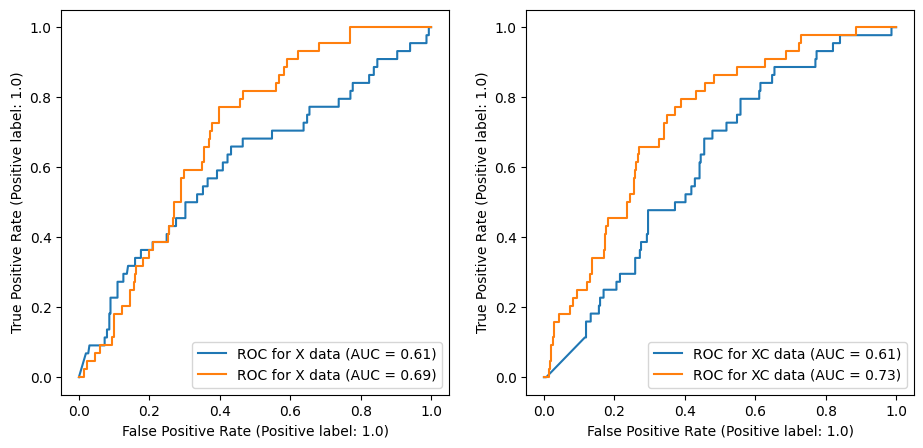

In [43]:
# Final Model Evaluations

#metrics_function
def metrics_func2(clf,x,y,cv=3):
  cv_acc = cross_val_score(clf,x,y,cv=cv,scoring='accuracy') # Cross-validated accuracy
  cv_precision = cross_val_score(clf,x,y,cv=cv,scoring='precision') # Cross-validated precision
  cv_recall = cross_val_score(clf,x,y,cv=cv,scoring='recall') # Cross-validated recall
  cv_f1 = cross_val_score(clf,x,y,cv=cv,scoring='f1') # Cross-validated f1
  return [np.mean(cv_acc),
          np.mean(cv_precision),
          np.mean(cv_recall),
          np.mean(cv_f1)]

otprows = ['Accuracy','Precision','Recall','F1-score']
optnames = ["MLP","SVC"]
optclf = [
    MLPClassifier(activation='relu', alpha=0.01, hidden_layer_sizes= (32, 64, 32, 8), learning_rate='constant', solver= 'lbfgs',
              max_iter = 20000, early_stopping = True, validation_fraction = 0.111, random_state=0),
    SVC(C=1, gamma=0.01, kernel = 'sigmoid', cache_size=2000, class_weight='balanced'),
]

fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))

opttestX = pd.DataFrame([], index=otprows, columns=optnames)
opttestXC=opttestX.copy()
for name, clf in zip(optnames, optclf):
  clf.fit(x_train, y_train)
  opttestX[name]=metrics_func2(clf,x_test, y_test,cv=3)
  RocCurveDisplay.from_estimator(clf,x_test, y_test, ax=ax1, name='ROC for X data')
  clf.fit(xc_train, yc_train)
  RocCurveDisplay.from_estimator(clf,xc_test, yc_test, ax=ax2, name='ROC for XC data')
  opttestXC[name]=metrics_func2(clf,xc_test, yc_test,cv=3)

<Axes: title={'center': 'Cross-validated classification XC data'}>

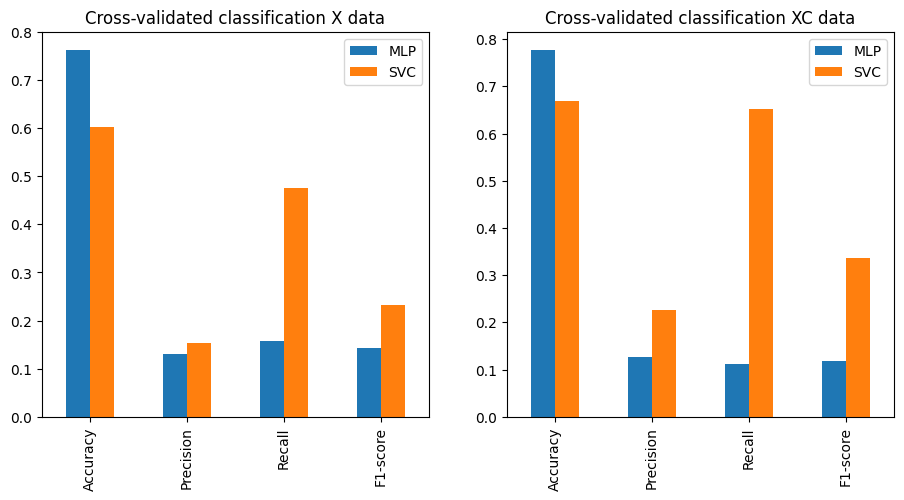

In [44]:
fig3, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))

tran_opttestX = pd.DataFrame.transpose(opttestX)
tran_opttestX.T.plot.bar(ax=ax1, title="Cross-validated classification X data")
tran_opttestXC = pd.DataFrame.transpose(opttestXC)
tran_opttestXC.T.plot.bar(ax=ax2,title="Cross-validated classification XC data")

All features importance - summary

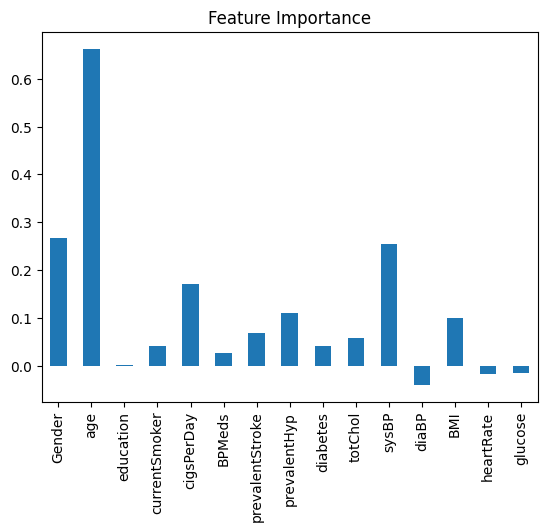

In [40]:
clfa = SVC(C=1000, gamma=0.1, kernel = 'linear', cache_size=2000, class_weight='balanced')
clfa.fit(xa_train, ya_train)

opttestXC['SVC all data']=metrics_func2(clfa,xc_test, yc_test,cv=3)

feature_importance = pd.DataFrame(dict(zip(xa.columns, list(clfa.coef_[0]))), index=[0])
feature_importance.T.plot.bar(title="Feature Importance", legend=False);